# Implementing Transmitter,  Channel and Receiver using Autoencoder
Apoorva Jha (15MI420), Harish (15MI421)

Ref : An Introduction to Deep Learning for the Physical Layer, Tim O’Shea, Senior Member, IEEE, and Jakob Hoydis, Member, IEEE

In [1]:
# importing required libs
import numpy as np
import keras
from keras.layers import Input, Dense, GaussianNoise, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras import regularizers

from keras import backend as K

Using TensorFlow backend.


In [2]:
# k is bits used in a message
# M is possible message
# n = no of channels
# R is communication rate
# n is used in encoder layers and R is used for defining noise for channel
M = 4
k = np.log2(M)
k = int(k)
n = 2
R = k/n
print (M,k,n,R)

4 2 2 1.0


In [19]:
#generating data of size N
N = 5000
from numpy.random import seed
seed(10)
pos = np.random.randint(M,size=N)

# creating one hot encoded vectors
train_data = []
for i in pos:
    arr = np.zeros(M)
    arr[i] = 1
    train_data.append(arr)

# checking data shape
train_data = np.array(train_data)
print (train_data.shape)

print(train_data[16])

(5000, 4)
[1. 0. 0. 0.]


In [20]:
# transmitter
message_signal = Input(shape=(M,))
transmitter1 = Dense(M, activation='relu')(message_signal)
transmitter2= Dense(n, activation='softmax',kernel_regularizer=regularizers.l2(0.01),
                activity_regularizer=regularizers.l2(0.01))(transmitter1)

# to avoid overfitting


#noise in channel
SNR = 10**(0.7) #  coverted 7 db of EbNo, values used from paper
channel = GaussianNoise(np.sqrt(1/(2*R*SNR)))(transmitter2)
#receiver
receiver1 = Dense(M, activation='relu')(channel)
receiver2 = Dense(M, activation='softmax')(receiver1)
autoencoder = Model(message_signal, receiver2)
autoencoder.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy') # learning rate value from paper

print (autoencoder.summary())

autoencoder.fit(train_data,train_data,
                epochs=100,
                batch_size=16)

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 4)                 0         
_________________________________________________________________
dense_9 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 10        
_________________________________________________________________
gaussian_noise_3 (GaussianNo (None, 2)                 0         
_________________________________________________________________
dense_11 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_12 (Dense)             (None, 4)                 20        
Total params: 62
Trainable params: 62
Non-trainable params: 0
_______________________________________________________________

5000/5000 [==============================] - 0s 51us/step - loss: 0.8475
Epoch 84/100
5000/5000 [==============================] - 0s 52us/step - loss: 0.8519
Epoch 85/100
5000/5000 [==============================] - 0s 58us/step - loss: 0.8327
Epoch 86/100
5000/5000 [==============================] - 0s 56us/step - loss: 0.8655
Epoch 87/100
5000/5000 [==============================] - 0s 45us/step - loss: 0.8428
Epoch 88/100
5000/5000 [==============================] - 0s 52us/step - loss: 0.8528
Epoch 89/100
5000/5000 [==============================] - 0s 45us/step - loss: 0.8504
Epoch 90/100
5000/5000 [==============================] - 0s 61us/step - loss: 0.8527
Epoch 91/100
5000/5000 [==============================] - 0s 64us/step - loss: 0.8537
Epoch 92/100
5000/5000 [==============================] - 0s 65us/step - loss: 0.8488
Epoch 93/100
5000/5000 [==============================] - 0s 64us/step - loss: 0.8520
Epoch 94/100
5000/5000 [==============================] - 0s 56us/s

In [21]:
#transmitter model
transmitter = Model(message_signal, transmitter2)

In [22]:
# receiver model
encoded_input = Input(shape=(n,))

deco = autoencoder.layers[-2](encoded_input)
deco = autoencoder.layers[-1](deco)
receiver = Model(encoded_input, deco)

In [23]:
# test data
N = 1000
from numpy.random import seed
seed(10)
test_pos = np.random.randint(M,size=N)
test_data = []

for i in test_pos:
    arr = np.zeros(M)
    arr[i] = 1
    test_data.append(arr)
    
test_data = np.array(test_data)
print (test_data.shape)
print (test_data[44])

(1000, 4)
[0. 1. 0. 0.]


In [24]:
# we now make our test data pass through the transmitter and rciever with different noise in the channel
#the bit error rate vs SNR graph is plotted showing how well the autoencoder models a communication system

SNR_range = (range(-15,16)) # decibel values
ber = [0]*len(SNR_range) # block error rate
for i in range(0,len(SNR_range)):
    SNR=10**(SNR_range[i]*0.1) # converting from decibel
    std = np.sqrt(1/(2*R*SNR))
    errors = 0
    from numpy.random import seed
    seed(10)
    noise = std * np.random.randn(N,n)# noise for channel
    #print(n,noise.shape)
    msg_signal = transmitter.predict(test_data) 
    transmit_signal = msg_signal + noise
    transmit_signal_received =  receiver.predict(transmit_signal)
    #print(transmit_signal)
    received_signal = np.argmax(transmit_signal_received,axis=1) #finding pos of bit 1
    #print(received_signal)
    errors = (received_signal != test_pos)# checking pos for bit 1
    #print(errors)
    errors =  errors.sum() 
    ber[i] = errors / N
   # errors=errors.sum()
   # ber[i] =(errors)/ N # normalizing
    #print(1)
    print ('SNR:',SNR_range[i],'BER:',ber[i])
    

SNR: -15 BER: 0.73
SNR: -14 BER: 0.722
SNR: -13 BER: 0.715
SNR: -12 BER: 0.708
SNR: -11 BER: 0.703
SNR: -10 BER: 0.689
SNR: -9 BER: 0.688
SNR: -8 BER: 0.692
SNR: -7 BER: 0.682
SNR: -6 BER: 0.67
SNR: -5 BER: 0.661
SNR: -4 BER: 0.649
SNR: -3 BER: 0.633
SNR: -2 BER: 0.624
SNR: -1 BER: 0.603
SNR: 0 BER: 0.586
SNR: 1 BER: 0.565
SNR: 2 BER: 0.54
SNR: 3 BER: 0.514
SNR: 4 BER: 0.485
SNR: 5 BER: 0.462
SNR: 6 BER: 0.434
SNR: 7 BER: 0.407
SNR: 8 BER: 0.374
SNR: 9 BER: 0.34
SNR: 10 BER: 0.318
SNR: 11 BER: 0.297
SNR: 12 BER: 0.28
SNR: 13 BER: 0.264
SNR: 14 BER: 0.26
SNR: 15 BER: 0.256


Text(0, 0.5, 'Block Error Rate')

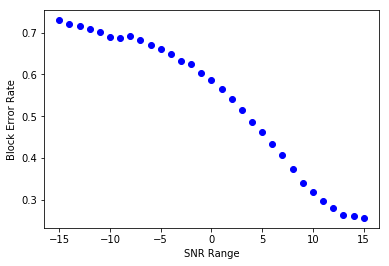

In [25]:
# ploting ber curve
import matplotlib.pyplot as plt
plt.plot(SNR_range, ber,'bo')
plt.xlabel('SNR Range')
plt.ylabel('Block Error Rate')
